# EDP Project 3

In [163]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier


In [164]:
conn = sqlite3.connect(':memory:')

In [165]:
tm_df = pd.read_csv("troop_movements.csv")

In [166]:
tm_df.head()

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld
0,2025-07-08 14:09:08,1,x-wing,empire,1,10,10,9,Malastare
1,2025-07-08 14:09:07,2,stormtrooper,empire,9,6,7,2,Tholoth
2,2025-07-08 14:09:06,3,tie_fighter,empire,9,2,5,10,Naboo
3,2025-07-08 14:09:05,4,resistance_soldier,resistance,6,1,8,8,Mon Cala
4,2025-07-08 14:09:04,5,resistance_soldier,empire,4,2,6,2,Toydaria


In [167]:
tm_df.to_sql('tm_df', conn, index=False, if_exists='replace')

1000

In [168]:
query = """
SELECT
empire_or_resistance,
COUNT(*) AS total_count
FROM tm_df
GROUP BY empire_or_resistance
ORDER BY total_count DESC;
"""
team_count = pd.read_sql_query(query, conn)
team_count.head()

,empire_or_resistance,total_count
0,resistance,503
1,empire,497


In [169]:
query = """
SELECT
homeworld,
COUNT(*) AS total_count
FROM tm_df
GROUP BY homeworld
ORDER BY total_count DESC;
"""
df = pd.read_sql_query(query, conn)
df.head(50)

,homeworld,total_count
0,Umbara,31
1,Quermia,29
2,Eriadu,29
3,Cerea,29
4,Glee Anselm,28
5,Dorin,28
6,Vulpter,27
7,Serenno,27
8,Kalee,27
9,Concord Dawn,27


In [170]:
query = """
SELECT
unit_type,
COUNT(*) AS total_count
FROM tm_df
GROUP BY unit_type
ORDER BY total_count DESC;
"""
df = pd.read_sql_query(query, conn)
df.head(50)

,unit_type,total_count
0,stormtrooper,136
1,at-st,133
2,tie_fighter,127
3,at-at,123
4,resistance_soldier,122
5,tie_silencer,121
6,x-wing,119
7,unknown,119


In [171]:
tm_df.head()

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld
0,2025-07-08 14:09:08,1,x-wing,empire,1,10,10,9,Malastare
1,2025-07-08 14:09:07,2,stormtrooper,empire,9,6,7,2,Tholoth
2,2025-07-08 14:09:06,3,tie_fighter,empire,9,2,5,10,Naboo
3,2025-07-08 14:09:05,4,resistance_soldier,resistance,6,1,8,8,Mon Cala
4,2025-07-08 14:09:04,5,resistance_soldier,empire,4,2,6,2,Toydaria


In [172]:
df = pd.get_dummies(tm_df, columns=['empire_or_resistance'], prefix='is')
df = df.drop(columns=['is_empire'])
df.head()

,timestamp,unit_id,unit_type,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2025-07-08 14:09:08,1,x-wing,1,10,10,9,Malastare,False
1,2025-07-08 14:09:07,2,stormtrooper,9,6,7,2,Tholoth,False
2,2025-07-08 14:09:06,3,tie_fighter,9,2,5,10,Naboo,False
3,2025-07-08 14:09:05,4,resistance_soldier,6,1,8,8,Mon Cala,True
4,2025-07-08 14:09:04,5,resistance_soldier,4,2,6,2,Toydaria,False


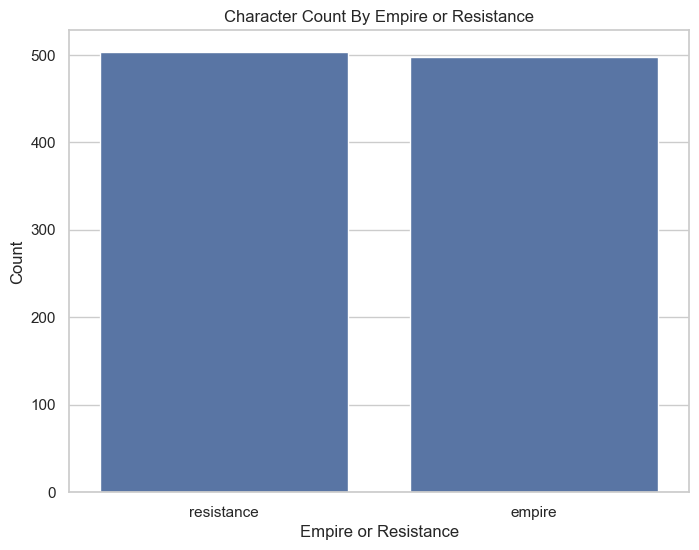

In [173]:
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))  # Set the size of the plot

# Create the bar plot
sns.barplot(x='empire_or_resistance', y='total_count', data=team_count)

# Add labels and title
plt.xlabel('Empire or Resistance')
plt.ylabel('Count')
plt.title('Character Count By Empire or Resistance')

# Show the plot
plt.show()

In [174]:
df['is_resistance'] = df['is_resistance'].astype(int)
df.head()

,timestamp,unit_id,unit_type,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2025-07-08 14:09:08,1,x-wing,1,10,10,9,Malastare,0
1,2025-07-08 14:09:07,2,stormtrooper,9,6,7,2,Tholoth,0
2,2025-07-08 14:09:06,3,tie_fighter,9,2,5,10,Naboo,0
3,2025-07-08 14:09:05,4,resistance_soldier,6,1,8,8,Mon Cala,1
4,2025-07-08 14:09:04,5,resistance_soldier,4,2,6,2,Toydaria,0


In [175]:
df_predictors = df[['homeworld', 'unit_type']]
df_predictors = pd.get_dummies(df_predictors, columns=['homeworld'], prefix='hw')
df_predictors = pd.get_dummies(df_predictors, columns=['unit_type'], prefix='unit_type')

df_predictors = df_predictors.astype(int)

df_predictors.head(10)

,hw_Alderaan,hw_Aleen Minor,hw_Bestine IV,hw_Cerea,hw_Champala,hw_Chandrila,hw_Concord Dawn,hw_Corellia,hw_Dagobah,hw_Dathomir,...,hw_Vulpter,hw_Zolan,unit_type_at-at,unit_type_at-st,unit_type_resistance_soldier,unit_type_stormtrooper,unit_type_tie_fighter,unit_type_tie_silencer,unit_type_unknown,unit_type_x-wing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [176]:
# Drop Columns Transformer. Ensure only valid predictor cols are fed to model
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep):
        self.columns_to_keep = columns_to_keep

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns_to_keep].copy()

In [177]:
categorical_features = ['homeworld', 'unit_type']

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

dt_pipeline = Pipeline(steps=[
    ('drop_columns', DropColumnsTransformer(categorical_features)),
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

dt_pipeline.fit(df[categorical_features], df["is_resistance"])

,steps,"[('drop_columns', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,columns_to_keep,"['homeworld', 'unit_type']"
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [178]:
feature_names = preprocessor.get_feature_names_out()

importances = dt_pipeline['classifier'].feature_importances_

features_importances = pd.DataFrame({"Feature": feature_names, 'Importance': importances}).sort_values(by='Importance',ascending=False)
features_importances.head()

,Feature,Importance
41,cat__unit_type_at-st,0.068534
43,cat__unit_type_stormtrooper,0.064787
31,cat__homeworld_Sullust,0.052407
6,cat__homeworld_Corellia,0.041336
42,cat__unit_type_resistance_soldier,0.040242


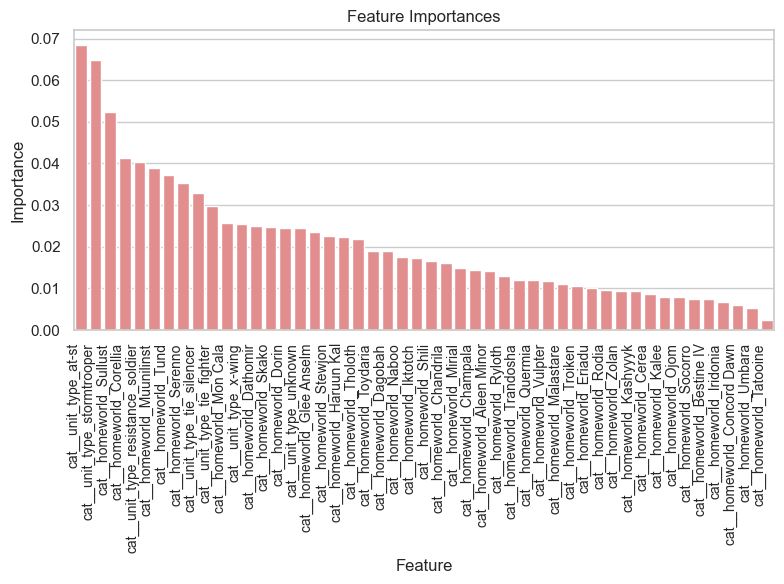

In [179]:
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(8, 6))  # Set the size of the plot

# Create the bar plot
sns.barplot(x='Feature', y='Importance', data=features_importances, color='lightcoral')

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

In [180]:
# Specify the file path to save the pipeline
file_path = 'trained_model.pkl'

# Save the pipeline to disk
with open(file_path, 'wb') as file:
    pickle.dump(dt_pipeline, file)

# Part 3: Use the Trained Model With "Real" Data

In [181]:
full_df = pd.read_csv("troop_movements_1m.csv")
full_df.head()

,timestamp,unit_id,unit_type,location_x,location_y,destination_x,destination_y,homeworld
0,2023-06-03 03:19:15,919214,tie_silencer,2.0,5.0,9,3,Aleen Minor
1,2023-02-24 13:50:40,9467154,stormtrooper,9.0,0.0,9,1,Malastare
2,2023-03-29 19:54:55,6585778,tie_silencer,0.0,6.0,5,9,Serenno
3,2023-04-30 00:58:11,3878023,tie_silencer,4.0,2.0,9,9,Tund
4,2023-04-10 22:00:26,5537117,at-st,6.0,8.0,5,8,Skako


In [182]:
full_df.to_sql('full_df', conn, index=False, if_exists='replace')

1000000

In [183]:
query = """
SELECT
unit_type,
COUNT(*)
FROM full_df
GROUP BY unit_type
ORDER BY count(*) DESC;
"""
df = pd.read_sql_query(query, conn)
df.head(50)

,unit_type,COUNT(*)
0,tie_silencer,143216
1,tie_fighter,142753
2,at-at,142724
3,resistance_soldier,142647
4,stormtrooper,142611
5,at-st,142554
6,x-wing,142494
7,invalid_unit,1001


In [184]:
full_df = full_df.replace('invalid_unit', 'unknown')


In [185]:
full_df.to_sql('full_df', conn, index=False, if_exists='replace')

1000000

In [186]:
full_df[['location_x', 'location_y']] = full_df[['location_x', 'location_y']].ffill()


In [187]:
query = """
SELECT
location_x,
location_y
FROM full_df
WHERE location_x IS NULL OR location_y IS NULL
"""
df = pd.read_sql_query(query, conn)
df.head(5)

,location_x,location_y
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None


In [188]:
with open(file_path, 'rb') as file:
    clf_pipe = pickle.load(file)

In [189]:
full_df.head()

,timestamp,unit_id,unit_type,location_x,location_y,destination_x,destination_y,homeworld
0,2023-06-03 03:19:15,919214,tie_silencer,2.0,5.0,9,3,Aleen Minor
1,2023-02-24 13:50:40,9467154,stormtrooper,9.0,0.0,9,1,Malastare
2,2023-03-29 19:54:55,6585778,tie_silencer,0.0,6.0,5,9,Serenno
3,2023-04-30 00:58:11,3878023,tie_silencer,4.0,2.0,9,9,Tund
4,2023-04-10 22:00:26,5537117,at-st,6.0,8.0,5,8,Skako


In [190]:
df_predictors = full_df[['homeworld', 'unit_type']]
df_predictors = pd.get_dummies(df_predictors, columns=['homeworld'], prefix='hw')
df_predictors = pd.get_dummies(df_predictors, columns=['unit_type'], prefix='unit_type')

df_predictors = df_predictors.astype(int)

In [191]:
full_df['predictions'] = clf_pipe.predict(full_df).astype(bool)
full_df.head(30)

,timestamp,unit_id,unit_type,location_x,location_y,destination_x,destination_y,homeworld,predictions
0,2023-06-03 03:19:15,919214,tie_silencer,2.0,5.0,9,3,Aleen Minor,False
1,2023-02-24 13:50:40,9467154,stormtrooper,9.0,0.0,9,1,Malastare,False
2,2023-03-29 19:54:55,6585778,tie_silencer,0.0,6.0,5,9,Serenno,False
3,2023-04-30 00:58:11,3878023,tie_silencer,4.0,2.0,9,9,Tund,False
4,2023-04-10 22:00:26,5537117,at-st,6.0,8.0,5,8,Skako,False
5,2023-04-06 19:26:03,5893460,x-wing,2.0,7.0,6,5,Troiken,True
6,2023-03-05 22:52:50,8653686,tie_silencer,6.0,9.0,1,9,Sullust,True
7,2023-03-26 10:26:45,6880282,tie_silencer,9.0,1.0,7,2,Troiken,False
8,2023-02-24 10:42:24,9478496,resistance_soldier,1.0,3.0,3,8,Stewjon,False
9,2023-05-10 22:57:10,2930983,tie_silencer,8.0,0.0,1,9,Quermia,True
